In [17]:
# GAN-MINE_XY (only use latent code z)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import itertools
from tqdm import tqdm
from data.mix_gaussian import MixedGaussian
from data.gaussian import Gaussian

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [18]:
chkpt_name = './results/GAN_MINEE/z_xy.pt'
parser = argparse.ArgumentParser()
parser.add_argument("--ref_batch_factor", type=int, default=300, help="ref_batch_factor")
parser.add_argument("--d", type=int, default=6, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=15000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
# parser.add_argument("--latent_dim", type=int, default=1, help="dimensionality of the latent space")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--alpha", type=float, default=0.99, help="RMSprop: smoothing constant ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")

# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()

In [19]:
def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

def _uniform_sample(data, batch_size):
    # Sample the reference uniform distribution
    data_min = data.min(dim=0)[0]
    data_max = data.max(dim=0)[0]
    return (data_max - data_min) * torch.rand((batch_size, data_min.shape[0])) + data_min

def _div(net, data, ref):
    # Calculate the divergence estimate using a neural network
    mean_f = net(data).mean()
    # log_mean_ef_ref = torch.exp(net(ref)-1).mean()
    log_mean_ef_ref = torch.logsumexp(net(ref), 0) - np.log(ref.shape[0])
    return mean_f - log_mean_ef_ref

class Generator(nn.Module):
    def __init__(self,y_dim, sigma=0.02):
        super(Generator, self).__init__()
        input_dim = opt.d
        hidden_size = opt.hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, y_dim)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, noise):
        gen_input = noise
        output = F.elu(self.fc1(gen_input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [20]:
seed = 0
rep = 1
# use GPU if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

np.random.seed(seed)
# initialize random seed
torch.manual_seed(seed)
mu1 = 0
mu2 = 0

rho = 0.9           # model parameter
rho2 = -0.9
rep = 1             # number of repeated runs

X = np.zeros((opt.sample_size,opt.d))
Y = np.zeros((opt.sample_size,opt.d))

# mg = MixedGaussian(sample_size=opt.sample_size,mean1=mu1, mean2=mu2,rho1=rho,rho2=rho2)
mg = Gaussian(sample_size=opt.sample_size,rho=rho)
mi = mg.ground_truth * opt.d
data = mg.data
for j in range(opt.d):
    data = mg.data
    X[:,j] = data[:,0]
    Y[:,j] = data[:,1]
X = torch.Tensor(X)
Y = torch.Tensor(Y)
# Initialize generator and discriminator
generator1 = Generator(y_dim=opt.d)
generator2 = Generator(y_dim=opt.d)
discriminator = Net(input_size=opt.d*2, hidden_size=100)

if cuda:
    generator1.cuda()
    generator2.cuda()
    discriminator.cuda()
# Optimizers Adam
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_G = torch.optim.Adam(
    itertools.chain(generator1.parameters(), generator2.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)

In [21]:
mi_list = []


for i in tqdm(range(opt.n_iters)):
    # z1 = FloatTensor(np.random.normal(0, 1, (opt.sample_size*opt.ref_batch_factor, opt.latent_dim)))
    # z2 = FloatTensor(np.random.normal(0, 1, (opt.sample_size*opt.ref_batch_factor, opt.latent_dim)))
    z = FloatTensor(np.random.normal(0, 1, (opt.sample_size*opt.ref_batch_factor, opt.d)))

    y_gen = generator1(z)
    x_gen = generator2(z)

    XY = torch.cat((X, Y), dim=1)
    X_ref = _resample(X, batch_size=X.shape[0])
    Y_ref = _resample(Y, batch_size=Y.shape[0])
    y_gen_ref = _resample(y_gen, batch_size=opt.batch_size*opt.ref_batch_factor)
    x_gen_ref = _resample(x_gen, batch_size=opt.batch_size*opt.ref_batch_factor)

    XY_ref = torch.cat((x_gen_ref, y_gen_ref), dim=1)
    batch_XY = _resample(XY, batch_size=opt.batch_size)
    batch_XY_gen_ref = torch.cat((x_gen_ref,y_gen_ref), dim=1)
    # -----------------
    #  Train Generator
    # -----------------
    optimizer_G.zero_grad()
    log_mean_ef_ref = torch.logsumexp(discriminator(batch_XY_gen_ref), 0) - np.log(batch_XY_gen_ref.shape[0])
    gen_loss = -log_mean_ef_ref
    gen_loss.backward()
    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------
    # define the loss function with moving average in the gradient estimate
    for _ in range(2):
        z = FloatTensor(np.random.normal(0, 1, (opt.sample_size*opt.ref_batch_factor, opt.d)))

        y_gen = generator1(z)
        x_gen = generator2(z)

        XY = torch.cat((X, Y), dim=1)
        X_ref = _resample(X, batch_size=X.shape[0])
        Y_ref = _resample(Y, batch_size=Y.shape[0])
        y_gen_ref = _resample(y_gen, batch_size=opt.batch_size*opt.ref_batch_factor)
        x_gen_ref = _resample(x_gen, batch_size=opt.batch_size*opt.ref_batch_factor)

        XY_ref = torch.cat((x_gen_ref, y_gen_ref), dim=1)
        batch_XY = _resample(XY, batch_size=opt.batch_size)
        batch_XY_gen_ref = torch.cat((x_gen_ref,y_gen_ref), dim=1)

        optimizer_D.zero_grad()
        mean_fXY = discriminator(batch_XY).mean()
        mean_efXY_ref = torch.exp(discriminator(batch_XY_gen_ref)).mean()
        opt.ma_ef = (1-opt.ma_rate)*opt.ma_ef + \
            opt.ma_rate*mean_efXY_ref
        batch_loss_XY = - mean_fXY + \
            (1 / opt.ma_ef).detach() * mean_efXY_ref
        batch_loss_XY.backward()
        optimizer_D.step()

    mi_list.append(_div(discriminator, XY, batch_XY_gen_ref).cpu().item())

torch.save(discriminator.state_dict(), chkpt_name)

100%|██████████| 15000/15000 [37:39&lt;00:00,  6.64it/s]


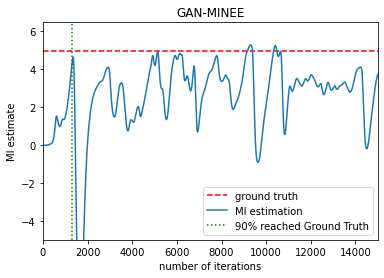

mi 4.982193620464953


In [25]:
mi_ma_rate = 0.01
mi_array = np.array(mi_list)
for i in range(1,len(mi_array)):
    mi_list[i] = (1-mi_ma_rate) * mi_list[i-1] + mi_ma_rate * mi_list[i]
    
plt.axhline(mi,label='ground truth',linestyle='--',color='red')
plt.plot(mi_list, label='MI estimation')

for t in range(len(mi_array)):
    if (mi_list[t]>.9*mi):
        plt.axvline(t,label='90% reached Ground Truth',linestyle=':',color='green')
        break

plt.xlim((0,opt.n_iters))
plt.ylim((-mi,mi*1.3))
plt.title('GAN-MINEE')
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.legend()
plt.savefig("./results/GAN_MINEE/Gaussian_z_xy_g2_d%d.png"%opt.d)

plt.show()
print('mi',mi)

In [23]:
# # plot the density ratio (discrimeter)
# N = 100
# arr = np.arange(N)
# np.random.shuffle(arr)
# x = np.linspace(-2,2,N)  
# x1, x2 = np.meshgrid(x,x)
# y = np.zeros((N,N))
# for i in range(N):
#     for j in range(N):
#         test_x = np.array([x1[i,j],x2[i,j]]).T
#         y[i,j] = discriminator(torch.Tensor(test_x))
# # test_x = np.array([x,x[arr]]).T
# # y = discriminator(torch.Tensor(test_x))

In [24]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(8, 5))
# ax = plt.axes(projection='3d', elev=50, azim=-50)
# ax.plot_surface(x1, x2, y, rstride=1, cstride=1, 
#                 edgecolor='none', alpha=.8, cmap=plt.get_cmap('rainbow'))
# # ax.plot_surface(x1, x2, y3, rstride=1, cstride=1, 
# #                 edgecolor='none', alpha=.8, cmap=plt.get_cmap('rainbow'))
# ax.set_xlabel('$x1$')
# ax.set_ylabel('$x2$')
# ax.set_zlabel('$z$')
# # plt.savefig('./surface3d.pdf')
# plt.show()